# READ ME
1. In this file there is a long function do_all_for_month() run it first.
2. Then run the second cell

In [1]:
def do_all_for_month(curr_data):
    import networkx as nx
    import matplotlib.pyplot as plt
    import folium
    import pandas as pd
    from folium.plugins import HeatMap
    from networkx.algorithms.community import greedy_modularity_communities
    import matplotlib.colors as mcolors
    import seaborn as sns

    # Rounding the latitude and longitude to create unique nodes
    curr_data['pickup_longitude'] = curr_data['pickup_longitude'].round(2)
    curr_data['pickup_latitude'] = curr_data['pickup_latitude'].round(2)
    curr_data['dropoff_longitude'] = curr_data['dropoff_longitude'].round(2)
    curr_data['dropoff_latitude'] = curr_data['dropoff_latitude'].round(2)

    # Initialize a directed graph
    G = nx.DiGraph()

    # Dictionary to count the frequency and aggregate data for each route
    route_data = {}

    # Iterate through each row to add edges to the graph
    for _, row in curr_data.iterrows():
        pickup = (row['pickup_latitude'], row['pickup_longitude'])
        dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])

        # Create a key for the route
        route = (pickup, dropoff)

        # Initialize or update aggregate data for the route
        if route not in route_data:
            route_data[route] = {
                'trip_count': 0,
                'total_distance': 0,
                'total_amount': 0,
                'total_passenger_count': 0
            }

        # Update the frequency and aggregate data
        route_data[route]['trip_count'] += 1
        route_data[route]['total_distance'] += row['trip_distance']
        route_data[route]['total_amount'] += row['total_amount']
        route_data[route]['total_passenger_count'] += row['passenger_count']

        # Calculate averages
        avg_distance = route_data[route]['total_distance'] / route_data[route]['trip_count']
        avg_amount = route_data[route]['total_amount'] / route_data[route]['trip_count']
        avg_passenger_count = route_data[route]['total_passenger_count'] / route_data[route]['trip_count']

        # Add the edge to the graph with average data
        G.add_edge(pickup, dropoff,
                   trip_count=route_data[route]['trip_count'],
                   avg_distance=avg_distance,
                   avg_amount=avg_amount,
                   avg_passenger_count=avg_passenger_count)

    # Visualize the graph
    # Define positions for the nodes using longitude and latitude
    positions = {node: (node[1], node[0]) for node in G.nodes}

    # Create a figure for the plot
    plt.figure(figsize=(12, 8))

    # Draw the graph
    nx.draw(G, pos=positions, node_size=10, edge_color='gray', alpha=0.5, with_labels=False)

    # Set labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Taxi Trips in New York (Network Visualization)')

    # Display the plot
    plt.grid(True)
    plt.show()

    # Calculate in-degree and out-degree for each node
    in_degree = dict(G.in_degree(weight='trip_count'))
    out_degree = dict(G.out_degree(weight='trip_count'))

    # Calculate total degree for each node
    total_degree = {node: in_degree[node] + out_degree[node] for node in G.nodes}

    # Prepare data for the heatmap: (latitude, longitude) pairs with weights (total degree)
    heat_data = [[node[0], node[1], total_degree[node]] for node in total_degree]

    # Create a base map centered around New York City
    nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

    # Add the heatmap layer with the total degree as the weight
    HeatMap(heat_data, radius=8, max_zoom=13).add_to(nyc_map)

    # Save the map to an HTML file
    nyc_map.save('nyc_total_degree_heatmap.html')

    # Display the map
    nyc_map

    # Extract edges with 'trip_count' greater than 5
    edges_with_more_than_5_trips = [(u, v, data) for u, v, data in G.edges(data=True) if data.get('trip_count', 0) > 150]

    # Display the number of such edges
    num_edges = len(edges_with_more_than_5_trips)
    print(f"Number of edges with more than 5 trips: {num_edges}")

    # Display the first few edges for inspection
    for edge in edges_with_more_than_5_trips[:5]:  # Showing the first 5 edges for brevity
        print(edge)

    # Calculate the in-degree and out-degree for each node
    in_degree = dict(G.in_degree(weight='trip_count'))
    out_degree = dict(G.out_degree(weight='trip_count'))

    # Calculate total degree for each node (sum of in-degree and out-degree)
    total_degree = {node: in_degree.get(node, 0) + out_degree.get(node, 0) for node in G.nodes}

    # Sort the nodes by in-degree, out-degree, and total degree in descending order and take the top 5
    top_5_in_degree = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:5]
    top_5_out_degree = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:5]
    top_5_total_degree = sorted(total_degree.items(), key=lambda x: x[1], reverse=True)[:5]

    # Display the top 5 nodes with the highest in-degree, out-degree, and total degree
    print("Top 5 Nodes by In-Degree:")
    for node, degree in top_5_in_degree:
        print(f"Node: {node}, In-Degree: {degree}")

    print("\nTop 5 Nodes by Out-Degree:")
    for node, degree in top_5_out_degree:
        print(f"Node: {node}, Out-Degree: {degree}")

    print("\nTop 5 Nodes by Total Degree:")
    for node, degree in top_5_total_degree:
        print(f"Node: {node}, Total Degree: {degree}")

    # Extract all edges with their data
    edges = list(G.edges(data=True))

    # Define a criterion for ranking (e.g., trip_count)
    # Sort the edges by 'trip_count' in descending order and take the top 5
    top_5_edges = sorted(edges, key=lambda x: x[2].get('trip_count', 0), reverse=True)[:5]

    # Display the top 5 edges with the highest trip_count
    print("Top 5 Edges by Trip Count:")
    for u, v, data in top_5_edges:
        print(f"Edge from {u} to {v}, Trip Count: {data['trip_count']}, Avg Distance: {data['avg_distance']}, Avg Amount: {data['avg_amount']}, Avg Passenger Count: {data['avg_passenger_count']}")

    # Calculate centrality measures for the nodes in the graph
    closeness_centrality = nx.closeness_centrality(G, distance='avg_distance')
    betweenness_centrality = nx.betweenness_centrality(G, weight='avg_distance')
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, weight='avg_distance')

    # Prepare the new table (DataFrame) to store the results
    edge_data = []

    # Iterate through each edge and gather required information
    for u, v, data in G.edges(data=True):
        edge_info = {
            'start_node': u,
            'end_node': v,
            'trip_count': data.get('trip_count', 0),
            'avg_distance': data.get('avg_distance', 0),
            'avg_amount': data.get('avg_amount', 0),
            'avg_passenger_count': data.get('avg_passenger_count', 0),
            'closeness_start': closeness_centrality[u],
            'closeness_end': closeness_centrality[v],
            'betweenness_start': betweenness_centrality[u],
            'betweenness_end': betweenness_centrality[v],
            'eigenvector_start': eigenvector_centrality[u],
            'eigenvector_end': eigenvector_centrality[v]
        }
        edge_data.append(edge_info)

    # Convert the list of edge data to a DataFrame
    edges_df = pd.DataFrame(edge_data)

    # Display the first few rows of the resulting DataFrame
    edges_df.head()

    # Define the boundaries of the popular area in New York
    min_lat, max_lat = 40.74, 40.77
    min_long, max_long = -73.99, -73.96

    # Add a new column to indicate whether the edge is within the popular area
    edges_df['in_popular_area'] = edges_df.apply(
        lambda row: (
            min_lat <= row['start_node'][0] <= max_lat and
            min_long <= row['start_node'][1] <= max_long and
            min_lat <= row['end_node'][0] <= max_lat and
            min_long <= row['end_node'][1] <= max_long
        ),
        axis=1
    )

    # Convert the boolean column to an integer (1 or 0)
    edges_df['in_popular_area'] = edges_df['in_popular_area'].astype(int)

    # Display the first few rows of the updated DataFrame
    edges_df.head()

    # Calculate centrality measures for nodes in the graph
    closeness_centrality = nx.closeness_centrality(G, distance='avg_distance')
    betweenness_centrality = nx.betweenness_centrality(G, weight='avg_distance')
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, weight='avg_distance')

    # Calculate degree centrality (total degree)
    degree_centrality = dict(G.degree(weight='trip_count'))

    # Sort and get top 10 nodes for each measure
    top_10_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    top_10_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    top_10_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    top_10_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

    # Display the top 10 nodes for each measure
    print("Top 10 Nodes by Closeness Centrality:")
    for node, value in top_10_closeness:
        print(f"Node: {node}, Closeness Centrality: {value}")

    print("\nTop 10 Nodes by Degree Centrality:")
    for node, value in top_10_degree:
        print(f"Node: {node}, Degree Centrality: {value}")

    print("\nTop 10 Nodes by Betweenness Centrality:")
    for node, value in top_10_betweenness:
        print(f"Node: {node}, Betweenness Centrality: {value}")

    print("\nTop 10 Nodes by Eigenvector Centrality:")
    for node, value in top_10_eigenvector:
        print(f"Node: {node}, Eigenvector Centrality: {value}")

    # Define a function to calculate the intersection and percentage of overlap
    def calculate_overlap_percentage(list1, list2):
        # Extract only the node identifiers (the first element of each tuple)
        nodes_list1 = set(node for node, _ in list1)
        nodes_list2 = set(node for node, _ in list2)

        # Calculate the intersection and percentage
        intersection = nodes_list1.intersection(nodes_list2)
        count = len(intersection)
        percentage = (count / len(nodes_list1)) * 100
        return count, percentage

    # Calculate the percentage of overlapping nodes for every top 10 list compared to each other
    def calculate_overall_overlap_percentage(lists):
        overlaps = {}
        for name1, list1 in lists.items():
            for name2, list2 in lists.items():
                if name1 != name2:
                    count, percentage = calculate_overlap_percentage(list1, list2)
                    overlaps[(name1, name2)] = percentage
        return overlaps

    # Store the top 10 lists in a dictionary for easier access
    top_10_lists = {
        'Closeness': top_10_closeness,
        'Degree': top_10_degree,
        'Betweenness': top_10_betweenness,
        'Eigenvector': top_10_eigenvector,
    }

    # Calculate the overlap percentages
    overall_overlap_percentages = calculate_overall_overlap_percentage(top_10_lists)

    # Display the overall results
    for (list1, list2), percentage in overall_overlap_percentages.items():
        print(f"Overlap Percentage from {list1} to {list2}: {percentage:.2f}%")

    # Extract node identifiers from top 10 lists
    degree_nodes = [node for node, _ in top_10_degree]
    closeness_nodes = [node for node, _ in top_10_closeness]

    # Create a unique set of nodes from both lists
    unique_nodes = set(degree_nodes + closeness_nodes)

    # Convert the set back to a list if you need a list format
    unique_nodes_list = list(unique_nodes)

    # Display the unique list of nodes
    print("Unique Nodes from Top 10 Degree and Top 10 Closeness Centrality:")
    print(unique_nodes_list)

    # Ensure 'start_node' and 'end_node' are tuples if not already
    edges_df['start_node'] = edges_df['start_node'].apply(tuple)
    edges_df['end_node'] = edges_df['end_node'].apply(tuple)

    # Create a set for efficient lookup
    unique_nodes_set = set(unique_nodes_list)

    # Filter edges where both start and end nodes are in unique_nodes_list
    edges_in_unique_nodes = edges_df[
        edges_df['start_node'].isin(unique_nodes_set) &
        edges_df['end_node'].isin(unique_nodes_set)
    ]

    # Count the number of such edges
    num_edges_in_unique_nodes = len(edges_in_unique_nodes)

    # Count the number of such edges that are also in the popular area
    num_edges_in_popular_area = edges_in_unique_nodes['in_popular_area'].sum()

    # Display the results
    print(f"Number of edges with both nodes in the unique list: {num_edges_in_unique_nodes}")
    print(f"Number of these edges in the popular area: {num_edges_in_popular_area}")

    # Optionally, display the filtered DataFrame
    edges_in_unique_nodes.head()

    # Calculate average total amount and average distance for the edges in the unique nodes
    average_total_amount = edges_in_unique_nodes['avg_amount'].mean()
    average_distance = edges_in_unique_nodes['avg_distance'].mean()

    # Display the additional results
    print(f"Average total amount for these edges: ${average_total_amount:.2f}")
    print(f"Average distance for these edges: {average_distance:.2f} units")

    # Optionally, display the filtered DataFrame with additional information
    edges_in_unique_nodes[['start_node', 'end_node', 'avg_amount', 'avg_distance', 'in_popular_area']].head()

    # Calculate the degree for each node
    node_degrees = dict(G.degree())

    # Function to calculate the edge degree
    def calculate_edge_degree(start_node, end_node):
        # Get the degrees of the start and end nodes
        degree_start = node_degrees[start_node]
        degree_end = node_degrees[end_node]
        # Sum the degrees to get the edge degree
        return degree_start + degree_end

    # Add the edge degree to each row in the edges_df DataFrame
    edges_df['edge_degree'] = edges_df.apply(
        lambda row: calculate_edge_degree(row['start_node'], row['end_node']),
        axis=1
    )

    # Display the updated DataFrame with the edge degree
    edges_df.head()

    # Convert the directed graph to an undirected graph for community detection
    G_undirected = G.to_undirected()

    # Apply the Greedy Modularity Maximization algorithm to find communities
    communities = list(greedy_modularity_communities(G_undirected, weight='trip_count'))

    # Create a dictionary to map each node to its community number
    community_map = {}
    for i, community in enumerate(communities):
        for node in community:
            community_map[node] = i

    # Function to get community number for a node
    def get_community(node):
        return community_map.get(node, -1)  # Return -1 if node is not found (though it should always be found)

    # Add community numbers to edge_df
    edges_df['start_node_community'] = edges_df['start_node'].map(get_community)
    edges_df['end_node_community'] = edges_df['end_node'].map(get_community)

    # Add a column for edges where both nodes are in the same community
    edges_df['same_community'] = edges_df['start_node_community'] == edges_df['end_node_community']

    # Display the updated DataFrame
    edges_df.head()

    # Create two separate DataFrames
    same_community_edges = edges_df[edges_df['same_community'] == False]
    different_community_edges = edges_df[edges_df['same_community'] == True]

    # Select only the numeric columns from the DataFrame for correlation calculation
    numeric_cols = same_community_edges.select_dtypes(include=['float64', 'int64'])

    # Calculate the correlation matrix from the numerical columns
    correlation_matrix = numeric_cols.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))

    # Draw the heatmap
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)

    # Set the title of the heatmap
    plt.title('Correlation Heatmap of Edge Attributes')

    # Display the heatmap
    plt.show()

    # Prepare a color palette
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Create a new Folium map centered around New York City
    nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

    # Add each node to the map, colored by its community
    for node in G.nodes():
        latitude, longitude = node  # Unpack the latitude and longitude
        community = community_map[node]
        color = colors[community % len(colors)]  # Cycle through the color list if there are more communities than colors

        folium.CircleMarker(
            location=(latitude, longitude),
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"Node: {node}<br>Community: {community}"
        ).add_to(nyc_map)

    # Save and display the map
    nyc_map.save('nyc_community_map.html')

    # Display the map (only works in Jupyter environments)
    return nyc_map


Mounted at /content/drive
Number of NaT values: 0


<ipython-input-1-c072f17e9686>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data['pickup_longitude'] = curr_data['pickup_longitude'].round(2)
<ipython-input-1-c072f17e9686>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data['pickup_latitude'] = curr_data['pickup_latitude'].round(2)
<ipython-input-1-c072f17e9686>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

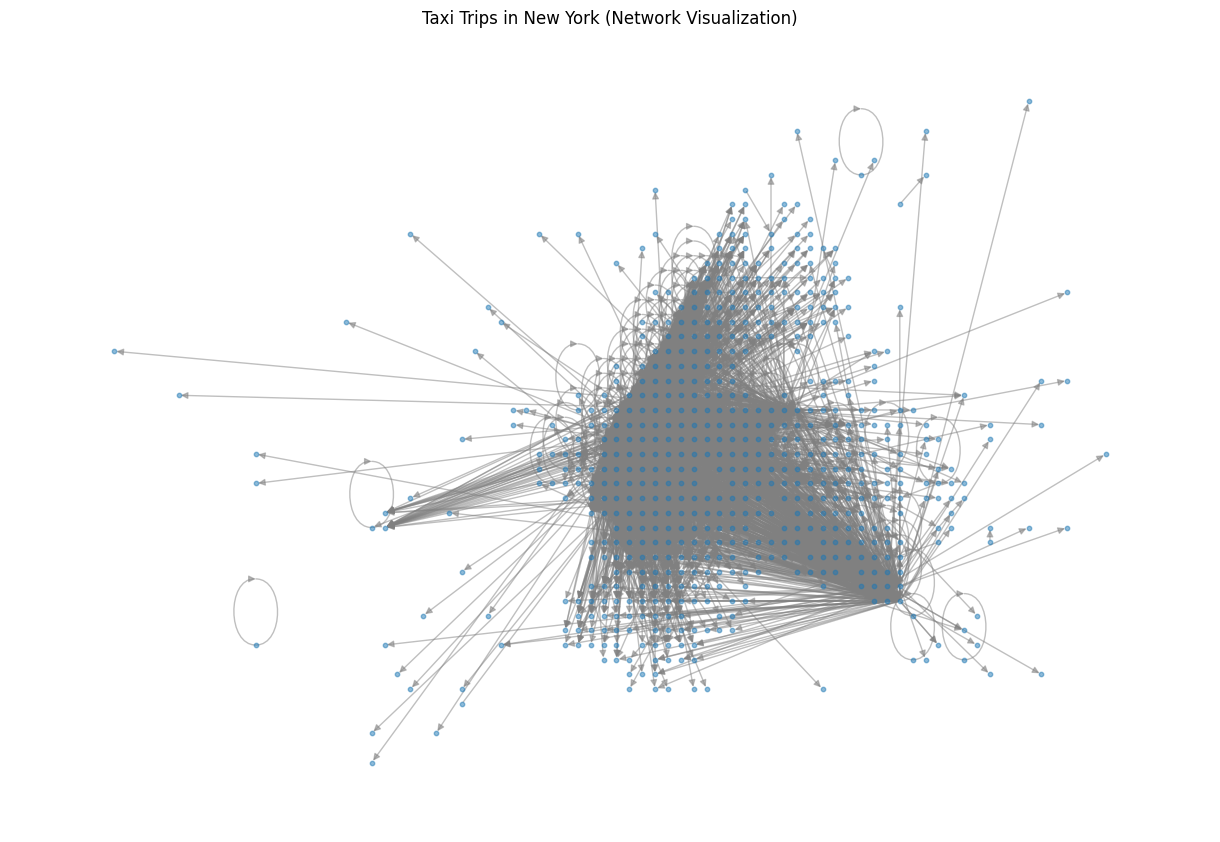

Number of edges with more than 5 trips: 22
((40.75, -73.99), (40.75, -73.98), {'trip_count': 207, 'avg_distance': 0.9587922705314011, 'avg_amount': 8.695893719806744, 'avg_passenger_count': 1.5603864734299517})
((40.75, -73.99), (40.74, -73.99), {'trip_count': 179, 'avg_distance': 0.93, 'avg_amount': 7.88620111731842, 'avg_passenger_count': 1.6033519553072626})
((40.75, -73.99), (40.76, -73.98), {'trip_count': 252, 'avg_distance': 1.2271825396825398, 'avg_amount': 9.83761904761905, 'avg_passenger_count': 1.5714285714285714})
((40.75, -73.99), (40.76, -73.99), {'trip_count': 211, 'avg_distance': 0.9299052132701425, 'avg_amount': 8.557345971563956, 'avg_passenger_count': 1.6635071090047393})
((40.77, -73.96), (40.76, -73.97), {'trip_count': 225, 'avg_distance': 1.0585777777777776, 'avg_amount': 8.994222222222202, 'avg_passenger_count': 1.528888888888889})
Top 5 Nodes by In-Degree:
Node: (40.76, -73.97), In-Degree: 2620
Node: (40.75, -73.99), In-Degree: 2446
Node: (40.76, -73.98), In-Degr

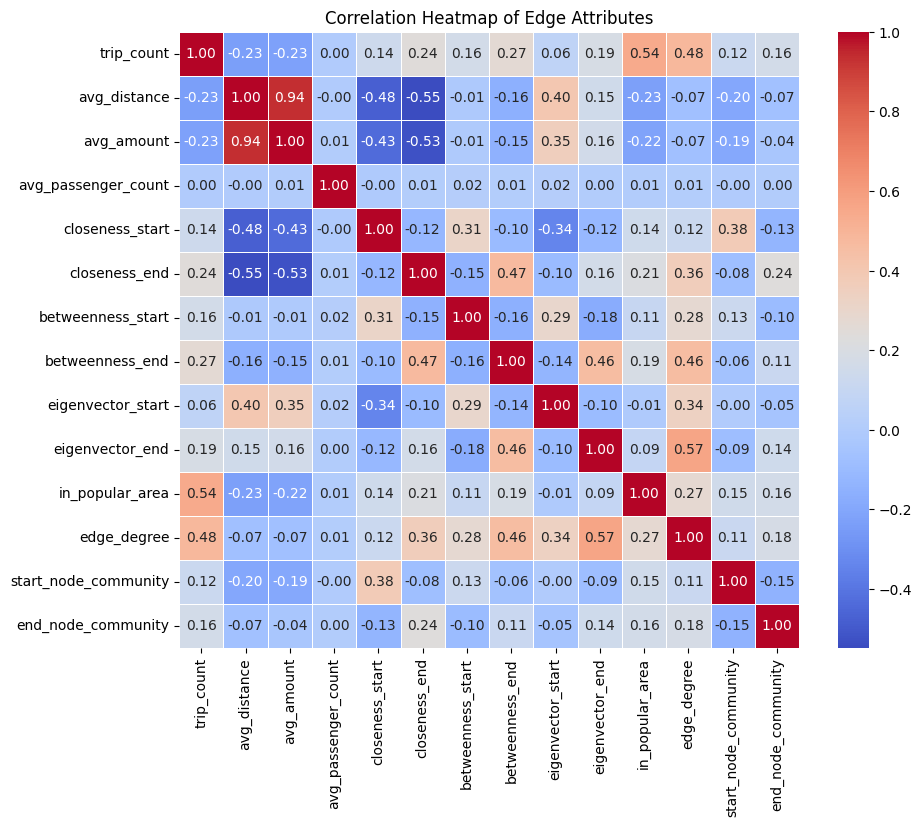

<ipython-input-1-c072f17e9686>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data['pickup_longitude'] = curr_data['pickup_longitude'].round(2)
<ipython-input-1-c072f17e9686>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data['pickup_latitude'] = curr_data['pickup_latitude'].round(2)
<ipython-input-1-c072f17e9686>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

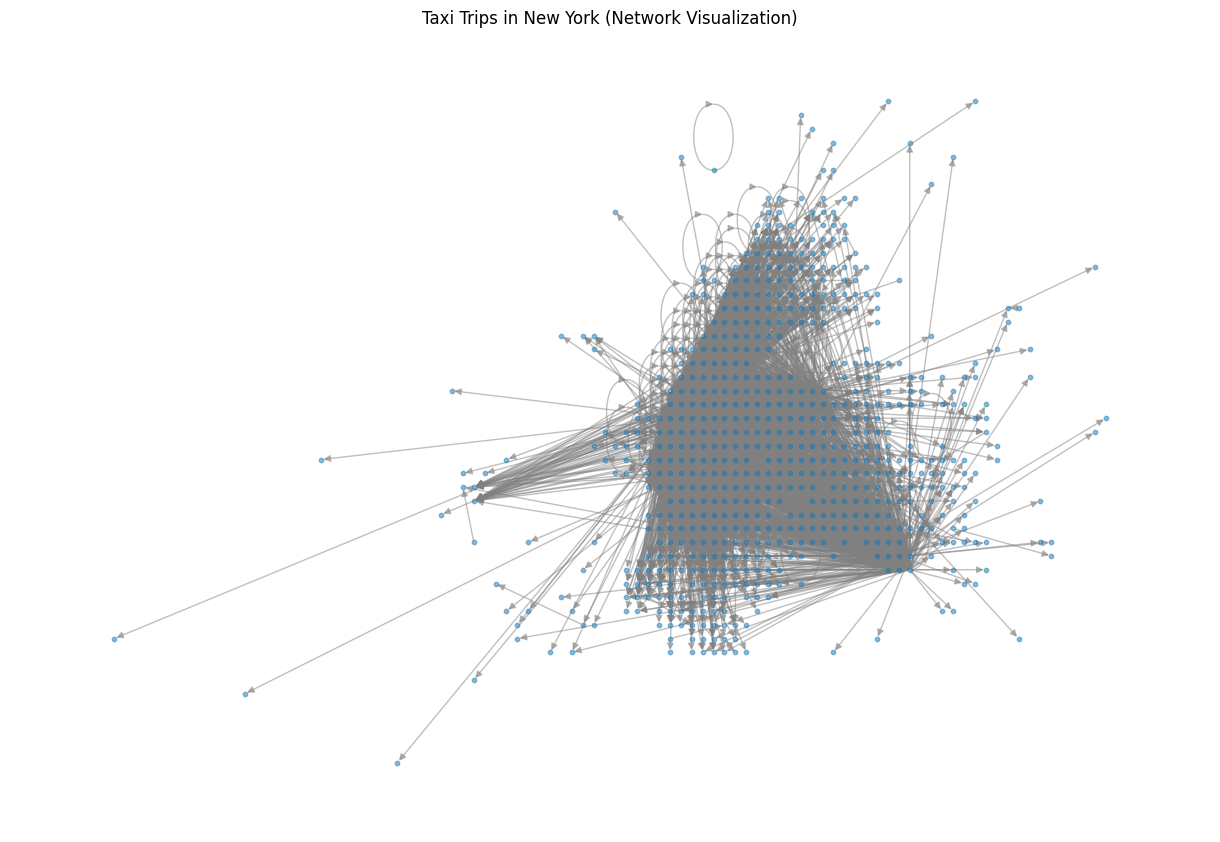

Number of edges with more than 5 trips: 17
((40.75, -73.98), (40.76, -73.98), {'trip_count': 158, 'avg_distance': 0.995506329113924, 'avg_amount': 8.726708860759476, 'avg_passenger_count': 1.7468354430379747})
((40.75, -73.98), (40.75, -73.99), {'trip_count': 186, 'avg_distance': 0.9035483870967743, 'avg_amount': 8.11338709677417, 'avg_passenger_count': 1.5806451612903225})
((40.75, -73.98), (40.76, -73.97), {'trip_count': 156, 'avg_distance': 1.065256410256411, 'avg_amount': 8.146153846153833, 'avg_passenger_count': 1.858974358974359})
((40.76, -73.99), (40.75, -73.99), {'trip_count': 243, 'avg_distance': 1.0234156378600823, 'avg_amount': 7.9723868312756965, 'avg_passenger_count': 1.831275720164609})
((40.76, -73.99), (40.76, -73.98), {'trip_count': 177, 'avg_distance': 0.865423728813559, 'avg_amount': 7.750621468926535, 'avg_passenger_count': 1.7005649717514124})
Top 5 Nodes by In-Degree:
Node: (40.75, -73.99), In-Degree: 2749
Node: (40.76, -73.98), In-Degree: 2325
Node: (40.76, -73.

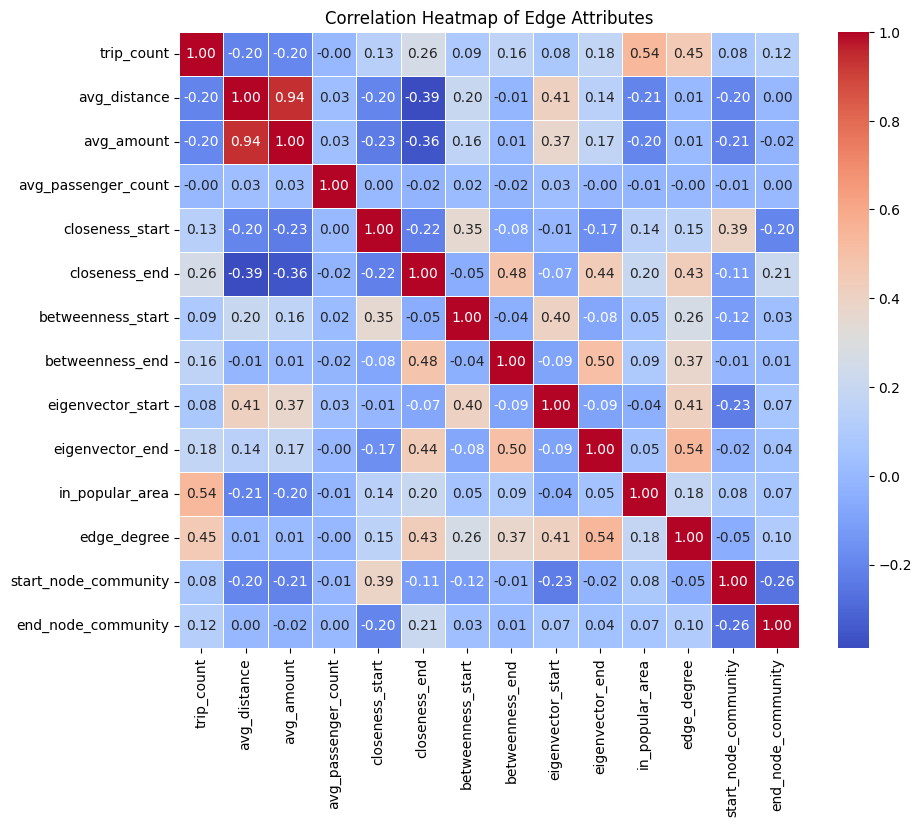

<ipython-input-1-c072f17e9686>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data['pickup_longitude'] = curr_data['pickup_longitude'].round(2)
<ipython-input-1-c072f17e9686>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data['pickup_latitude'] = curr_data['pickup_latitude'].round(2)
<ipython-input-1-c072f17e9686>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

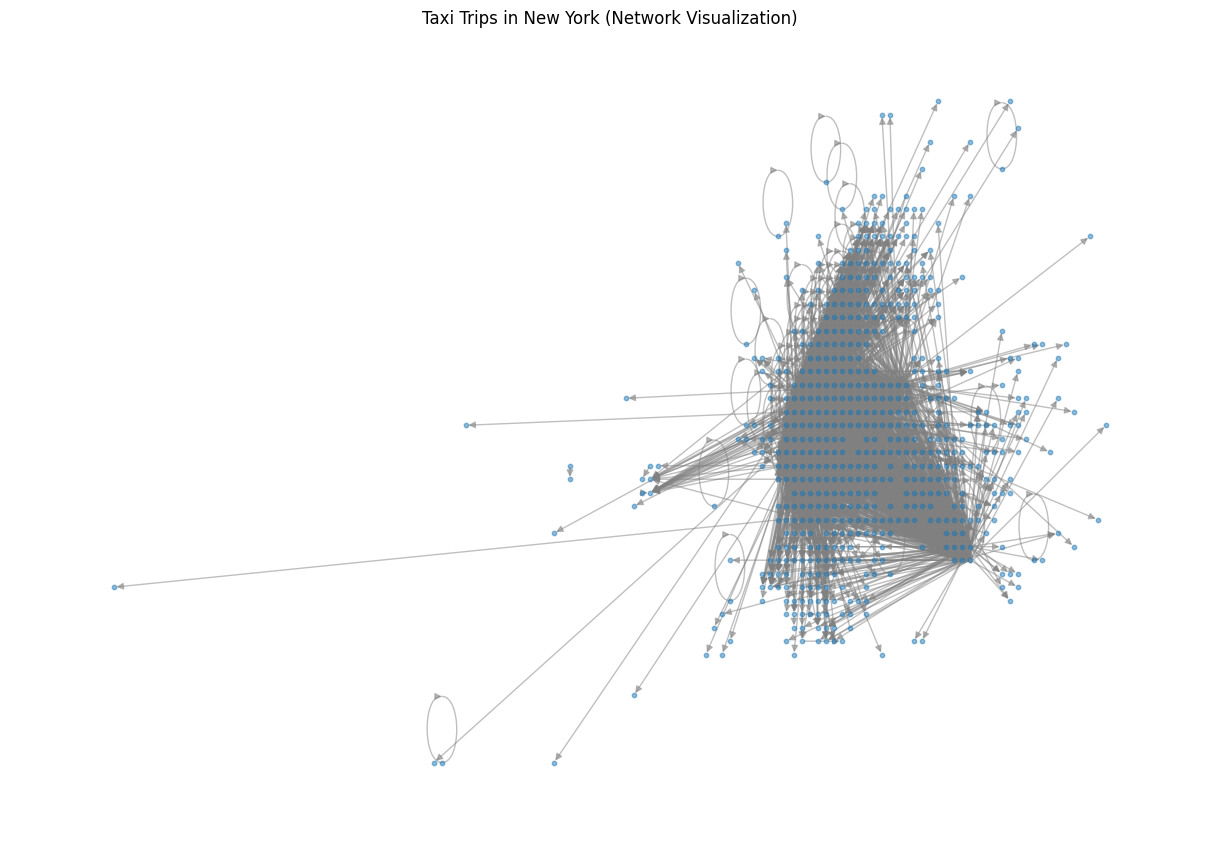

Number of edges with more than 5 trips: 29
((40.75, -73.98), (40.75, -73.99), {'trip_count': 252, 'avg_distance': 0.8948412698412702, 'avg_amount': 9.182539682539682, 'avg_passenger_count': 1.757936507936508})
((40.75, -73.98), (40.76, -73.97), {'trip_count': 278, 'avg_distance': 1.0174820143884893, 'avg_amount': 10.341115107913687, 'avg_passenger_count': 1.564748201438849})
((40.75, -73.98), (40.74, -73.99), {'trip_count': 200, 'avg_distance': 1.0986500000000001, 'avg_amount': 8.974849999999986, 'avg_passenger_count': 1.76})
((40.75, -73.98), (40.75, -73.98), {'trip_count': 151, 'avg_distance': 0.6389403973509935, 'avg_amount': 7.882251655629125, 'avg_passenger_count': 1.609271523178808})
((40.75, -73.98), (40.76, -73.98), {'trip_count': 227, 'avg_distance': 0.9733480176211454, 'avg_amount': 11.498281938326004, 'avg_passenger_count': 1.5726872246696035})
Top 5 Nodes by In-Degree:
Node: (40.76, -73.97), In-Degree: 3032
Node: (40.76, -73.98), In-Degree: 2965
Node: (40.75, -73.98), In-De

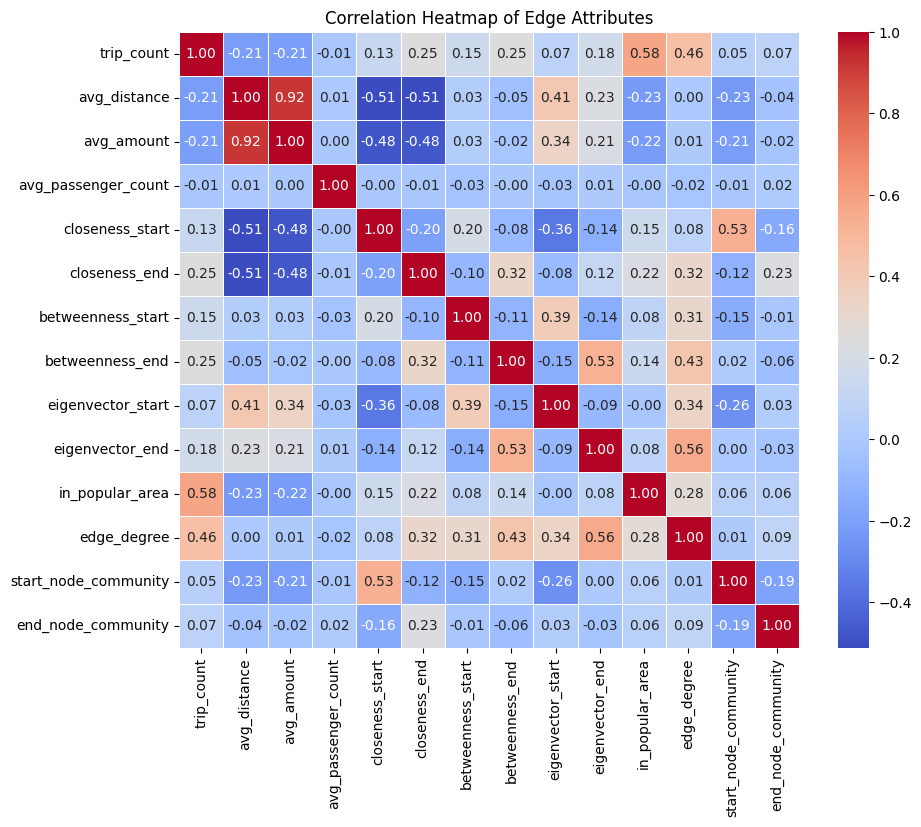

<ipython-input-1-c072f17e9686>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data['pickup_longitude'] = curr_data['pickup_longitude'].round(2)
<ipython-input-1-c072f17e9686>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data['pickup_latitude'] = curr_data['pickup_latitude'].round(2)
<ipython-input-1-c072f17e9686>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

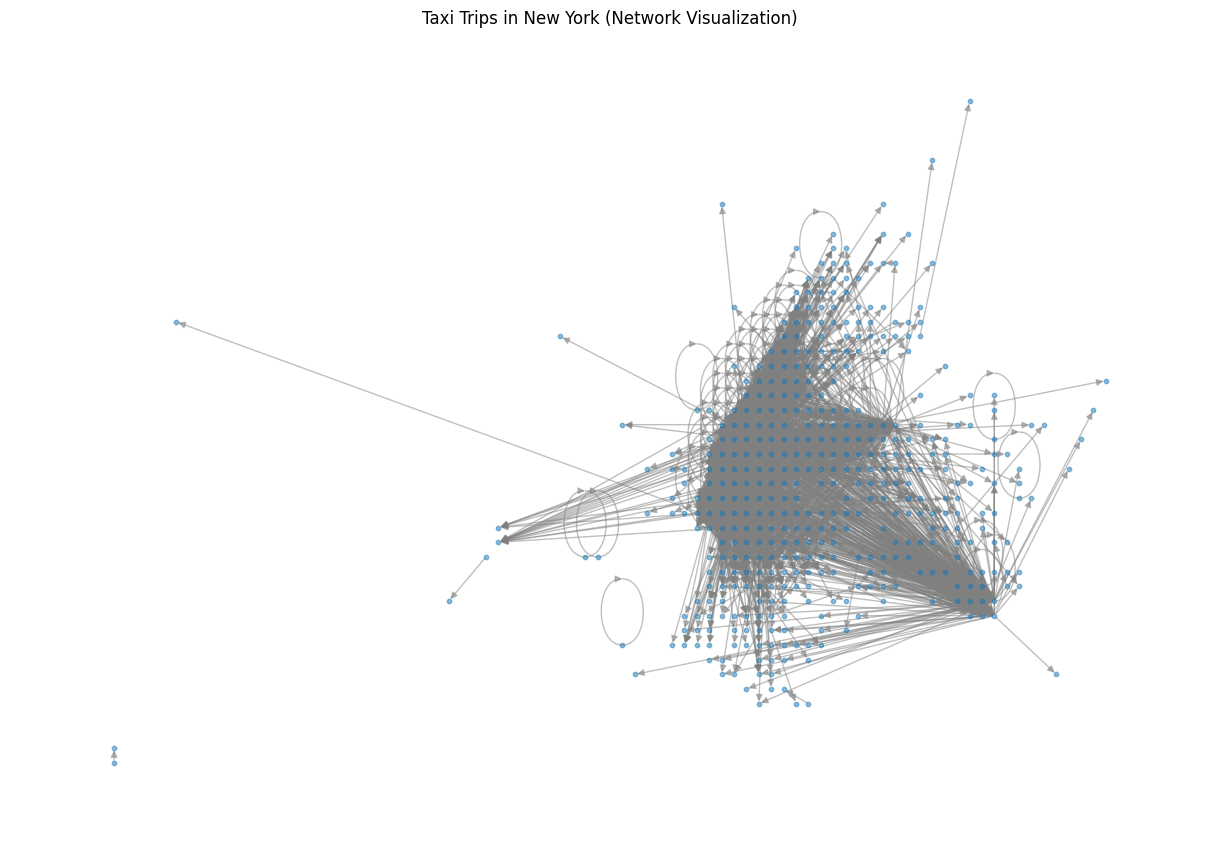

Number of edges with more than 5 trips: 1
((40.75, -73.99), (40.76, -73.98), {'trip_count': 152, 'avg_distance': 1.1883552631578942, 'avg_amount': 10.36881578947367, 'avg_passenger_count': 1.6776315789473684})
Top 5 Nodes by In-Degree:
Node: (40.76, -73.98), In-Degree: 1304
Node: (40.76, -73.97), In-Degree: 1233
Node: (40.75, -73.98), In-Degree: 1065
Node: (40.75, -73.99), In-Degree: 1050
Node: (40.74, -73.99), In-Degree: 841

Top 5 Nodes by Out-Degree:
Node: (40.76, -73.97), Out-Degree: 1413
Node: (40.76, -73.98), Out-Degree: 1237
Node: (40.75, -73.99), Out-Degree: 1151
Node: (40.75, -73.98), Out-Degree: 1099
Node: (40.74, -73.99), Out-Degree: 947

Top 5 Nodes by Total Degree:
Node: (40.76, -73.97), Total Degree: 2646
Node: (40.76, -73.98), Total Degree: 2541
Node: (40.75, -73.99), Total Degree: 2201
Node: (40.75, -73.98), Total Degree: 2164
Node: (40.74, -73.99), Total Degree: 1788
Top 5 Edges by Trip Count:
Edge from (40.75, -73.99) to (40.76, -73.98), Trip Count: 152, Avg Distance:

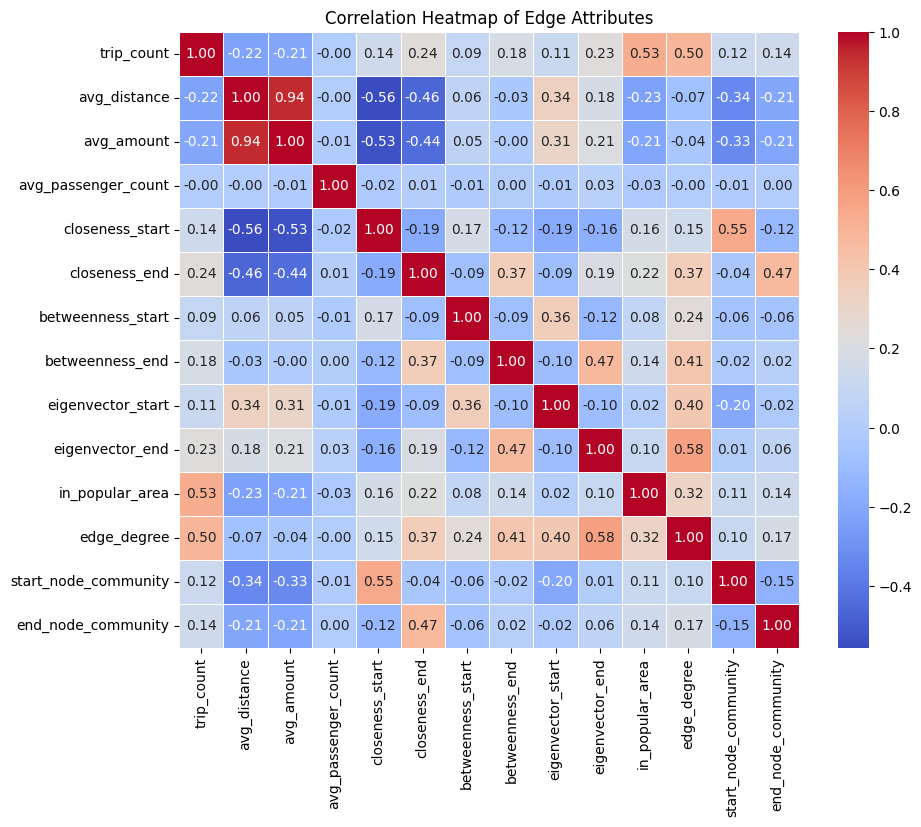

In [2]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Define the path to your CSV file
file_path = '/content/drive/My Drive/Taxi_200k.xlsx'

# Load the CSV file into a DataFrame
data = pd.read_excel(file_path)

taxi_data = data[(data != 0).all(axis=1)]

# Display the first few rows of the DataFrame
taxi_data.head()

# Define boundaries for New York City
min_longitude, max_longitude = -76.00, -73.6
min_latitude, max_latitude = 40.23, 41.0

##################################################

# Filter out data points that fall outside the NYC bounding box
filtered_taxi_data = taxi_data[
    (taxi_data['pickup_latitude'] >= min_latitude) &
    (taxi_data['pickup_latitude'] <= max_latitude) &
    (taxi_data['pickup_longitude'] >= min_longitude) &
    (taxi_data['pickup_longitude'] <= max_longitude) &
    (taxi_data['dropoff_latitude'] >= min_latitude) &
    (taxi_data['dropoff_latitude'] <= max_latitude) &
    (taxi_data['dropoff_longitude'] >= min_longitude) &
    (taxi_data['dropoff_longitude'] <= max_longitude)
]

# Display the size of the filtered dataset
len(filtered_taxi_data)

##################################################

# Ensure datetime conversion using .loc to avoid SettingWithCopyWarning
filtered_taxi_data.loc[:, 'tpep_pickup_datetime'] = pd.to_datetime(filtered_taxi_data['tpep_pickup_datetime'])

# Check for NaT values after conversion
nat_count = filtered_taxi_data['tpep_pickup_datetime'].isna().sum()
print(f"Number of NaT values: {nat_count}")

# Apply date filtering correctly
january_15_data = filtered_taxi_data[(filtered_taxi_data['tpep_pickup_datetime'] >= '2015-01-01') & (filtered_taxi_data['tpep_pickup_datetime'] <= '2015-01-31')]
january_16_data = filtered_taxi_data[(filtered_taxi_data['tpep_pickup_datetime'] >= '2016-01-01') & (filtered_taxi_data['tpep_pickup_datetime'] < '2016-02-01')]
february_16_data = filtered_taxi_data[(filtered_taxi_data['tpep_pickup_datetime'] >= '2016-02-01') & (filtered_taxi_data['tpep_pickup_datetime'] < '2016-03-01')]
march_16_data = filtered_taxi_data[(filtered_taxi_data['tpep_pickup_datetime'] >= '2016-03-01') & (filtered_taxi_data['tpep_pickup_datetime'] < '2016-04-01')]

# Display the number of records in each dataset to confirm the filtering
len(january_15_data), len(january_16_data), len(february_16_data), len(march_16_data)


do_all_for_month(january_15_data)
do_all_for_month(january_16_data)
do_all_for_month(february_16_data)
do_all_for_month(march_16_data)